# Setup

In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns

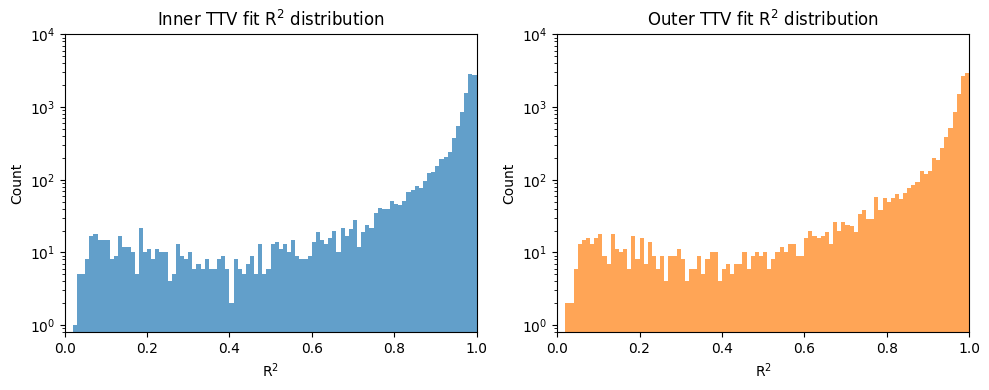

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,...,res1,A2,B2,V2,Pttv2,phase2,std2,res2,R2_1,R2_2
0,0.033107,123.085314,0.017329,178.313912,0.023051,2,7,14.322712,2.614537,1.454722,...,0.000016,1.153698e-04,-1.282734e-07,0.001746,310.897036,5.331669,0.001228,0.000047,0.998494,0.998540
1,0.017978,306.906940,0.083517,57.538634,-0.034996,2,7,13.510050,0.443966,6.351021,...,0.000391,2.383205e-05,1.066915e-08,0.000173,191.294908,1.645564,0.000132,0.000050,0.916962,0.853596
2,0.151408,252.517518,0.012288,331.263186,0.036891,2,7,14.516478,29.377281,3.313212,...,0.000190,4.501807e-03,-2.245622e-05,0.038897,191.046741,4.625618,0.027899,0.002758,0.990213,0.990224
3,0.015121,226.896829,0.030822,213.094073,0.047007,2,7,14.658091,2.106177,212.841690,...,0.001745,-1.022368e-07,5.932510e-08,0.000116,148.846849,0.062029,0.000082,0.000019,0.981559,0.948373
4,0.034984,22.599356,0.013887,263.872751,-0.048699,2,7,13.318220,40.448479,10.665445,...,0.000142,-1.612091e-03,2.695607e-06,0.004572,135.174202,2.070543,0.003338,0.000839,0.932696,0.936778


In [2]:
# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
fits = fits[fits.valid == True]
total = len(fits)

# R2-score histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(fits['R2_1'], bins=100, color='C0', alpha=0.7, range=(0, 1))
ax[0].set_title('Inner TTV fit R$^2$ distribution')

ax[1].hist(fits['R2_2'], bins=100, color='C1', alpha=0.7, range=(0, 1))
ax[1].set_title('Outer TTV fit R$^2$ distribution')

for a in ax:
    a.set_xlabel('R$^2$'); a.set_ylabel('Count')
    a.set_ylim(0.8,1e+4); a.set_xlim(0,1)
    a.set_yscale('log')

plt.tight_layout()
plt.show()

fits.head()

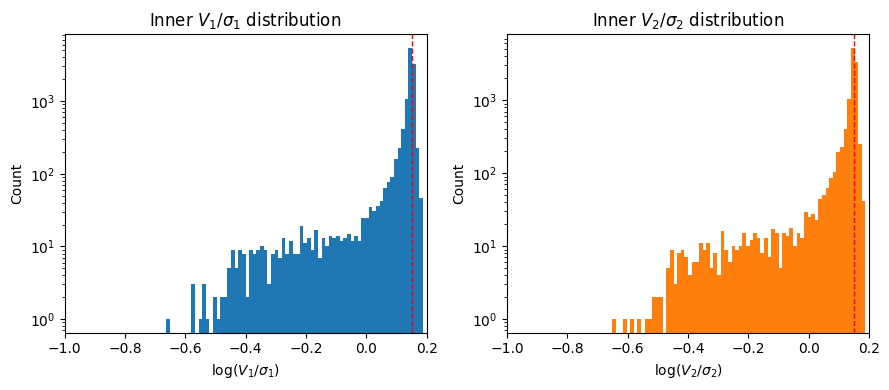

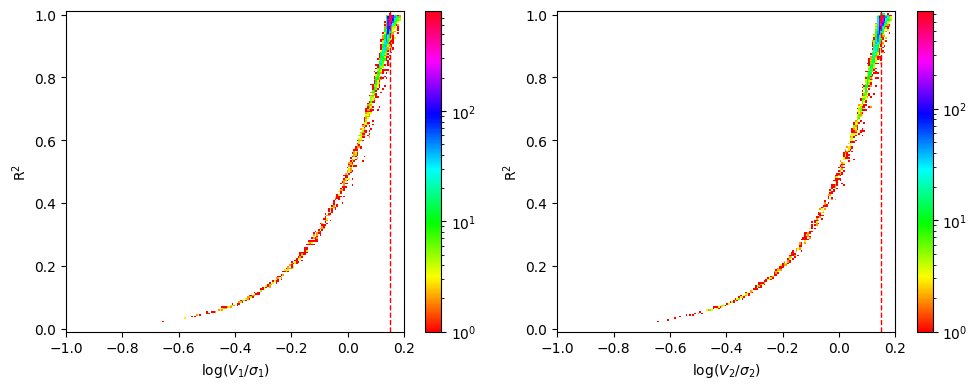

In [3]:
# Fit Amplitude / dispersion
amp_goodness1 = np.log10(np.abs(fits.V1) / fits.std1)
amp_goodness2 = np.log10(np.abs(fits.V2) / fits.std2)

# V/sigma histograms
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
rng = (-1, 0.2)
ax[0].hist(amp_goodness1, bins=100, range=rng, color='C0')
ax[1].hist(amp_goodness2, bins=100, range=rng, color='C1')

for i, a in enumerate(ax):
    a.set_title(f'Inner $V_{i+1}/\sigma_{i+1}$ distribution')
    a.set_yscale('log')
    a.set_xlim(rng)
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('Count')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# V/sigma-R2 scatterplot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

rng = [(-1, 0.2), (-0.01, 1.01)]
h0 = ax[0].hist2d(amp_goodness1, fits.R2_1, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')
h1 = ax[1].hist2d(amp_goodness2, fits.R2_2, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')

plt.colorbar(h0[3], ax=ax[0])
plt.colorbar(h1[3], ax=ax[1])

for i, a in enumerate(ax):
    a.set_xlim(rng[0]), a.set_ylim(rng[1])
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('R$^2$')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

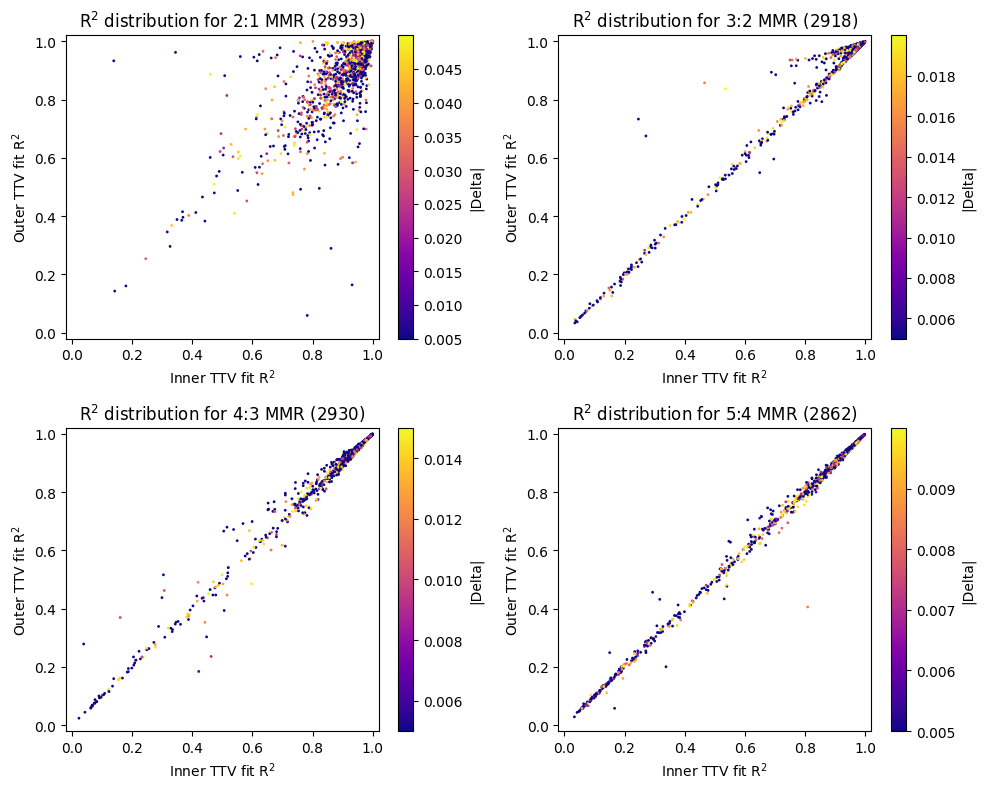

In [4]:
# R2-score scatterplots 1
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'Delta'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    vmax = fits[ccol][jmask].max()
    vmin = fits[ccol][jmask].min()
    jtot = jmask.sum()

    # Create custom colormap: blue at vmin, yellow at 0, red at vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    zero = (0 - vmin) / (vmax - vmin)
    colors = [
        (0.0, 'blue'),    # vmin
        ((0.0 + zero)/2, 'limegreen'),
        (zero, 'yellow'), # at 0
        ((1.0 + zero)/2, 'orange'),
        (1.0, 'red')      # vmax
    ]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    
    sc = ax[coords].scatter(fits['R2_1'][jmask], fits['R2_2'][jmask], s=1,
                            c=fits[ccol][jmask], cmap='plasma', vmin=0.005)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='|Delta|')

plt.tight_layout()
plt.show()

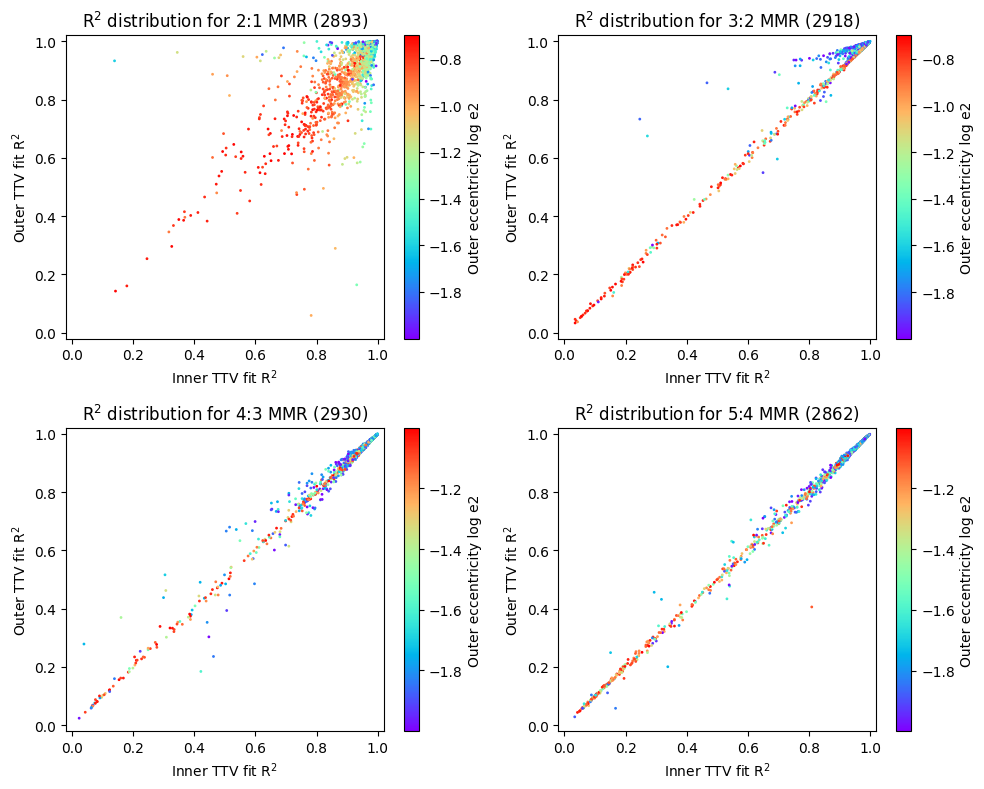

In [5]:
# R2-score scatterplots
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'e2'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    jtot = jmask.sum()
    # vmax = -0.5; vmin = -2.0
    
    sc = ax[coords].scatter(fits['R2_1'][jmask], fits['R2_2'][jmask], s=1,
                            c=np.log10(fits[ccol][jmask]),
                            cmap='rainbow')
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Outer eccentricity log e2')

plt.tight_layout()
plt.show()

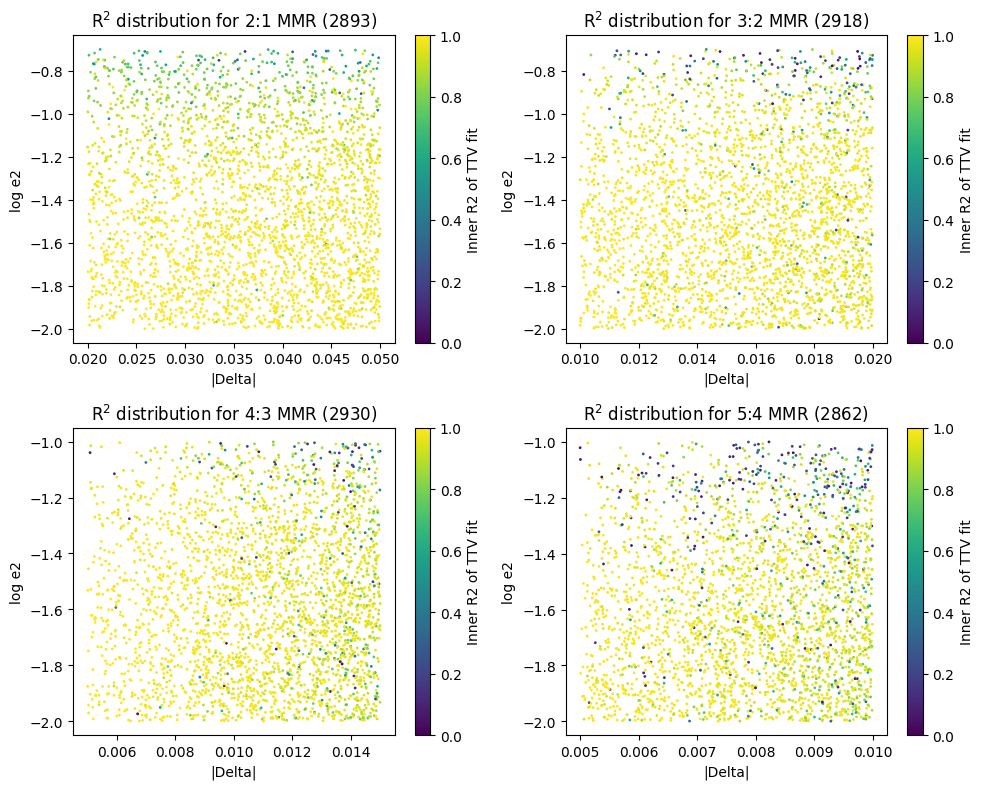

In [6]:
# R2-score scatterplots 3
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'e2'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    jtot = jmask.sum()
    
    sc = ax[coords].scatter(np.abs(fits['Delta'][jmask]), np.log10(fits[ccol][jmask]), s=1,
                            c=fits['R2_1'][jmask],
                            cmap='viridis', vmin=0, vmax=1)
    ax[coords].set_xlabel('|Delta|'); ax[coords].set_ylabel('log e2')
    # ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Inner R2 of TTV fit')

plt.tight_layout()
plt.show()

In [7]:
# Filter by R2 (Unused)
p5_1 = np.nanpercentile(fits.R2_1, 0)
p5_2 = np.nanpercentile(fits.R2_2, 0)
print(f'Filter for R^2 (Inner TTV) and R^2 (Outer TTV): {p5_1:.3f}, {p5_2:.3f}')

R2_filter = (fits.R2_1 > p5_1) & (fits.R2_2 > p5_2)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Filter for R^2 (Inner TTV) and R^2 (Outer TTV): 0.023, 0.024
Good systems: 11602/11603 (99.99%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,res1,A2,B2,V2,Pttv2,phase2,std2,res2,R2_1,R2_2
0,0,0.033107,123.085314,0.017329,178.313912,0.023051,2,7,14.322712,2.614537,...,0.000016,1.153698e-04,-1.282734e-07,0.001746,310.897036,5.331669,0.001228,0.000047,0.998494,0.998540
1,1,0.017978,306.906940,0.083517,57.538634,-0.034996,2,7,13.510050,0.443966,...,0.000391,2.383205e-05,1.066915e-08,0.000173,191.294908,1.645564,0.000132,0.000050,0.916962,0.853596
2,2,0.151408,252.517518,0.012288,331.263186,0.036891,2,7,14.516478,29.377281,...,0.000190,4.501807e-03,-2.245622e-05,0.038897,191.046741,4.625618,0.027899,0.002758,0.990213,0.990224
3,3,0.015121,226.896829,0.030822,213.094073,0.047007,2,7,14.658091,2.106177,...,0.001745,-1.022368e-07,5.932510e-08,0.000116,148.846849,0.062029,0.000082,0.000019,0.981559,0.948373
4,4,0.034984,22.599356,0.013887,263.872751,-0.048699,2,7,13.318220,40.448479,...,0.000142,-1.612091e-03,2.695607e-06,0.004572,135.174202,2.070543,0.003338,0.000839,0.932696,0.936778


In [8]:
# Functions, returns in %
def relerr(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    return relerrs

def err_gmean(calc, sol):
    relerrs = relerr(calc, sol)
    gavg = gmean(relerrs)
    return gavg

def err_med(calc, sol):
    relerrs = relerr(calc, sol)
    med = np.median(relerrs)
    return med

def err_gstd(calc, sol):
    relerrs = relerr(calc, sol)    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd

def err_1sig_percentiles(calc, sol):
    relerrs = relerr(calc, sol)
    p16 = np.percentile(relerrs, 16)
    p84 = np.percentile(relerrs, 84)
    return p16, p84

def num2dex(x):
    return np.log10(x)

def returnMetrics(df, mask='all', mode='gstd'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])

    if mode == 'gstd':
        gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
        gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])
    
        MetricArr = err1, err2, med1, med2, gstd1, gstd2
        MetricArr = num2dex(MetricArr)
        
    elif mode == 'percentile':
        p16_1, p84_1 = err_1sig_percentiles(df['m_calc_in'][m], df['m1'][m])
        p16_2, p84_2 = err_1sig_percentiles(df['m_calc_out'][m], df['m2'][m])

        MetricArr = err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2
        MetricArr = num2dex(MetricArr)
        
    return MetricArr

In [9]:
# Fit line y = kx + c
def getLineFit(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3)
    x, y = sol[nonan], calc[nonan]

    # Linear fit using scipy
    slope, intercept, _, _, _ = linregress(x, y)
    return slope, intercept

# Non-nominal validation

In [10]:
# Naive validation
valid = fits['valid']
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|███████████████████████████████████████████████████████████████████████████| 11602/11602 [01:34<00:00, 122.81it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,Pttv2,phase2,std2,res2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,0,0.033107,123.085314,0.017329,178.313912,0.023051,2,7,14.322712,2.614537,...,310.897036,5.331669,0.001228,0.000047,0.998494,0.998540,2.744814,1.565143,2.232970,0.957907
1,1,0.017978,306.906940,0.083517,57.538634,-0.034996,2,7,13.510050,0.443966,...,191.294908,1.645564,0.000132,0.000050,0.916962,0.853596,0.353323,5.650445,0.589849,8.518146
2,2,0.151408,252.517518,0.012288,331.263186,0.036891,2,7,14.516478,29.377281,...,191.046741,4.625618,0.027899,0.002758,0.990213,0.990224,32.589660,3.819348,27.261033,2.601288
3,3,0.015121,226.896829,0.030822,213.094073,0.047007,2,7,14.658091,2.106177,...,148.846849,0.062029,0.000082,0.000019,0.981559,0.948373,3.134077,202.180859,1.466584,145.384708
4,4,0.034984,22.599356,0.013887,263.872751,-0.048699,2,7,13.318220,40.448479,...,135.174202,2.070543,0.003338,0.000839,0.932696,0.936778,33.445346,11.703891,24.446915,4.543732


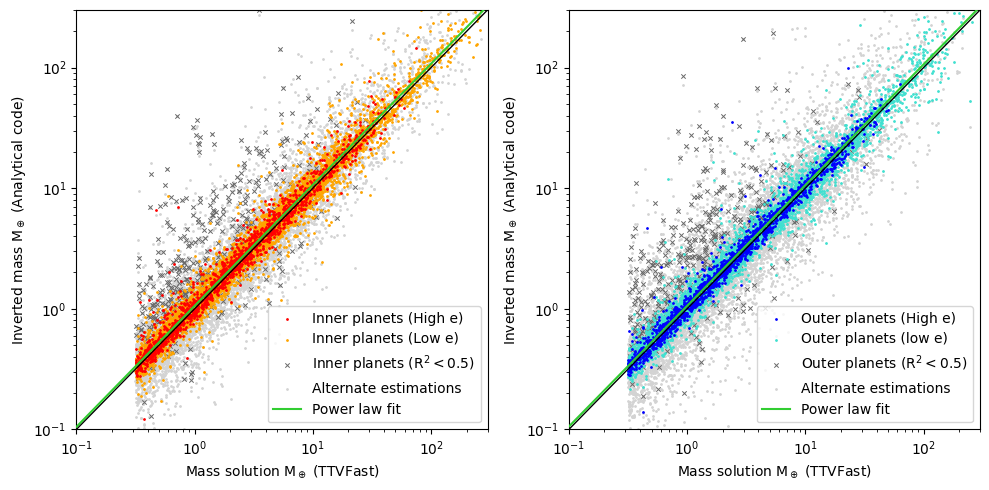

In [11]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 3e+2
linelim = np.array([minval, maxval])
scatterCount = len(compare['m1'])

ethres = 0.1
lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
Rthres = 0.5
lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

# Inner planets
m1 = compare['m1']
m1_good = compare['m_calc_in']
m1_bad = compare['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe &highR], m1_good[highe &highR], s=s, color='red', label=f'Inner planets (High e)', zorder=3)
ax[0].scatter(m1[lowe &highR], m1_good[lowe &highR], s=s, color='orange', label=f'Inner planets (Low e)', zorder=1)
ax[0].scatter(m1[lowR], m1_good[lowR], s=10*s, color='dimgrey', marker='x', lw=0.7, label=f'Inner planets (R$^2 < 0.5$)', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1)

ax[0].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', zorder=5, label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
m2 = compare['m2']
m2_good = compare['m_calc_out']
m2_bad = compare['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe &highR], m2_good[highe &highR], s=s, color='blue', label=f'Outer planets (High e)', zorder=3)
ax[1].scatter(m2[lowe &highR], m2_good[lowe &highR], s=s, color='turquoise', label=f'Outer planets (low e)', zorder=1)
ax[1].scatter(m2[lowR], m2_good[lowR], s=10*s, color='dimgrey', marker='x', lw=0.7, label=f'Outer planets (R$^2 < 0.5$)', zorder=0)
ax[1].scatter(m2, m2_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1)

ax[1].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', zorder=5, label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

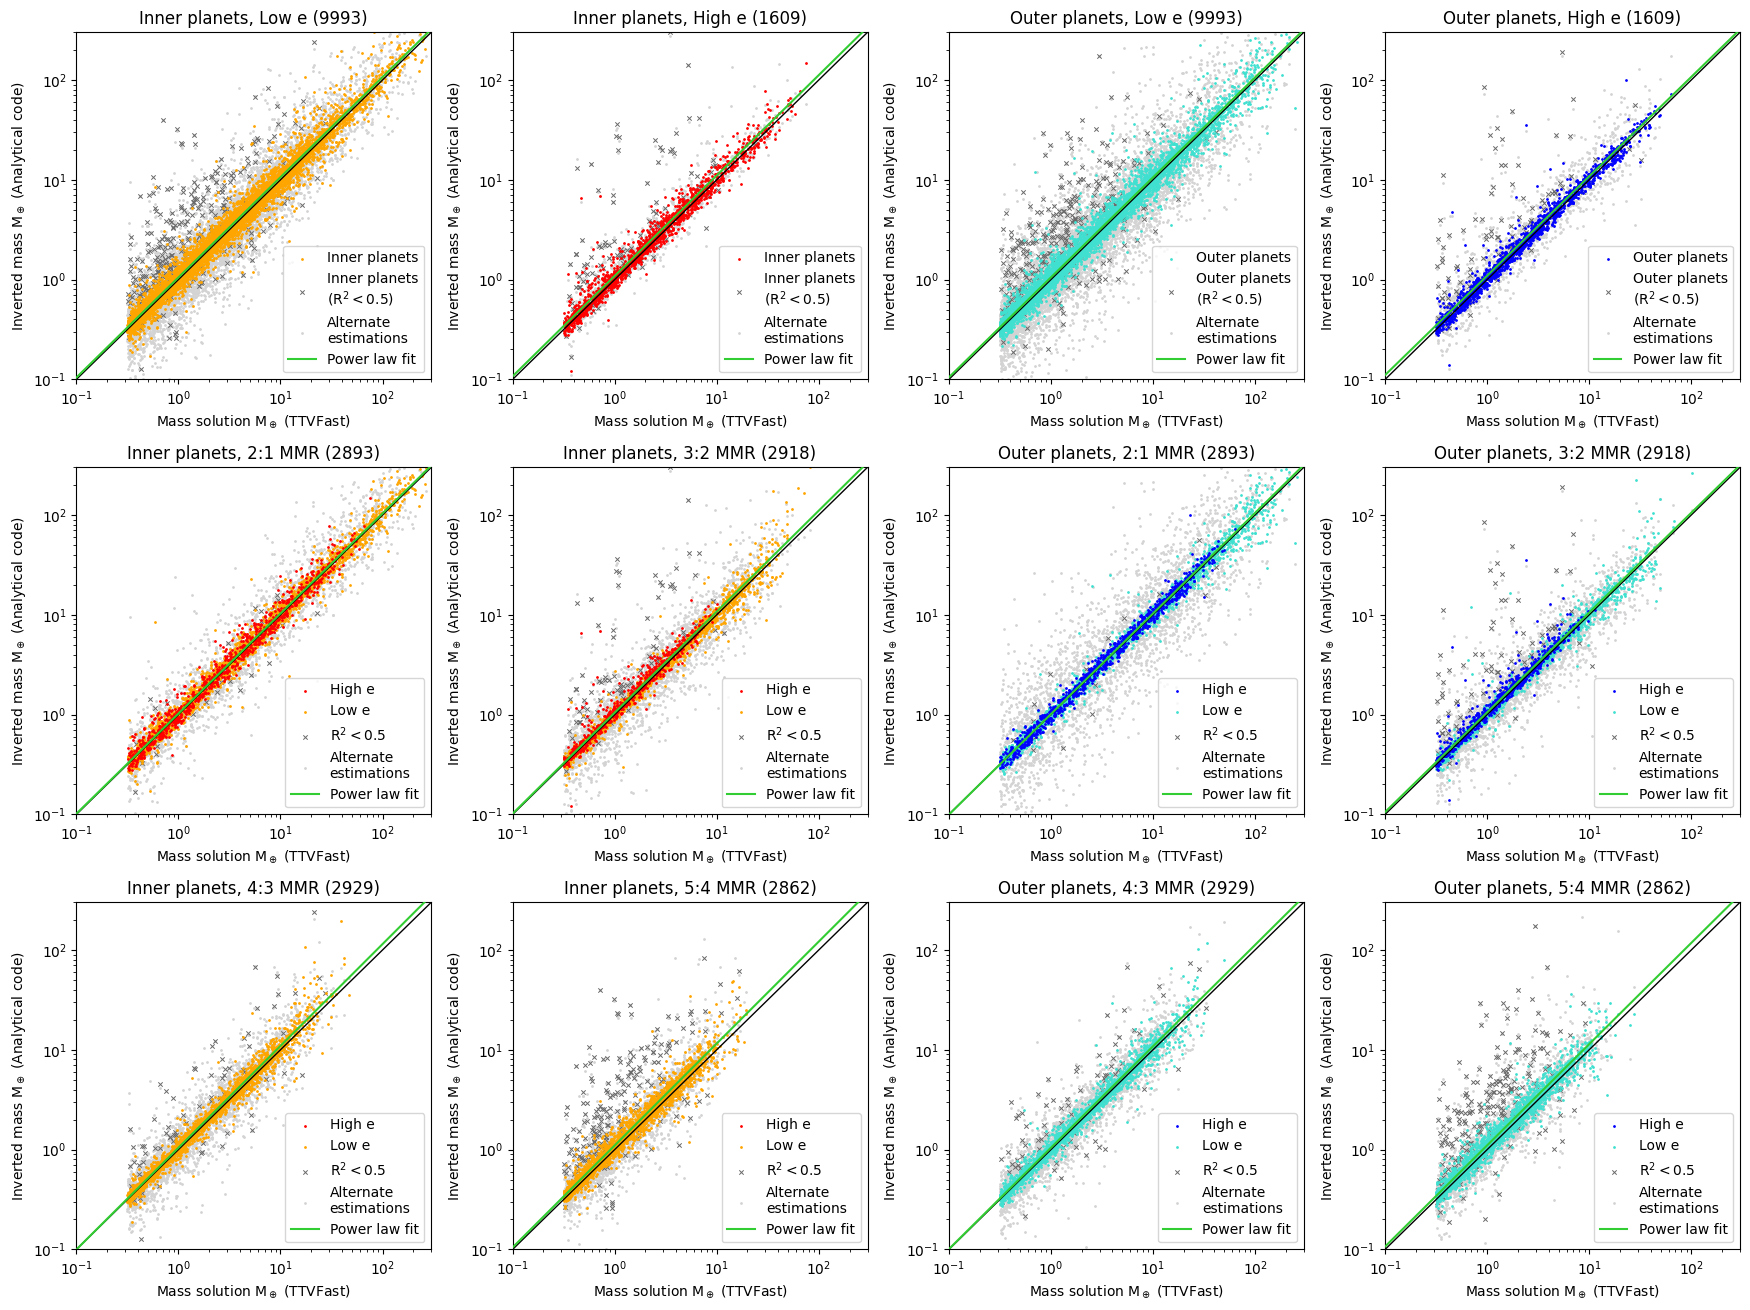

In [12]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName, mode='eccentricity'):
    s = 1
    minval = 1e-1
    maxval = 3e+2
    linelim = np.array([minval, maxval])
    scatterCount = len(x[mask])
    k, c = getLineFit(np.log10(ygood[mask]), np.log10(x[mask]))

    Rthres = 0.5
    lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

    if mode == 'eccentricity':
        ax[posTuple].scatter(x[mask &highR], ygood[mask &highR], s=s, color=color, label=f'{innerouterStr} planets', zorder=1)
        ax[posTuple].scatter(x[mask & lowR], ygood[mask & lowR], s=10*s,
                             color='dimgrey', marker='x', lw=0.7, label=f'{innerouterStr} planets\n(R$^2 < 0.5$)', zorder=0)
    elif mode == 'MMR':
        ethres = 0.1
        lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
        
        if color == 'red':
            altcolor = 'orange'
        elif color == 'blue':
            altcolor = 'turquoise'

        ax[posTuple].scatter(x[mask & highe &highR], ygood[mask & highe &highR], s=s, color=color, label=f'High e', zorder=2)
        ax[posTuple].scatter(x[mask & lowe &highR], ygood[mask & lowe &highR], s=s, color=altcolor, label=f'Low e', zorder=1)
        ax[posTuple].scatter(x[mask & lowR], ygood[mask & lowR], s=10*s, 
                             color='dimgrey', marker='x', label=f'R$^2 < 0.5$', lw=0.7, zorder=0)
    
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='lightgrey', label='Alternate\nestimations', zorder=-1)
    ax[posTuple].plot(linelim, linelim, color='black', lw=1, zorder=5)
    ax[posTuple].plot(linelim, 10**c * linelim**k, color='limegreen', zorder=5, label=f'Power law fit')
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName} ({scatterCount})')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.1
    lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'orange', 'Inner', lowe, 'Low e')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe, 'High e')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'turquoise', 'Outer', lowe, 'Low e')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe, 'High e')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR', mode='MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR', mode='MMR')
    plotMassEstimation((2,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR', mode='MMR')
    plotMassEstimation((2,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR', mode='MMR')
    
    plotMassEstimation((1,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR', mode='MMR')
    plotMassEstimation((1,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR', mode='MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR', mode='MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR', mode='MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [13]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.032 dex, 0.019 dex, 0.127 dex
Geometric mean error, median error, and geometric STD (Outer): 0.031 dex, 0.019 dex, 0.126 dex


# Nominal validation

In [14]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|████████████████████████████████████████████████████████████████████████████| 11602/11602 [02:15<00:00, 85.53it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,Pttv2,phase2,std2,res2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,0,0.033107,123.085314,0.017329,178.313912,0.023051,2,7,14.322712,2.614537,...,310.897036,5.331669,0.001228,0.000047,0.998494,0.998540,17.029548,2.830179,11.404737,2.489766
1,1,0.017978,306.906940,0.083517,57.538634,-0.034996,2,7,13.510050,0.443966,...,191.294908,1.645564,0.000132,0.000050,0.916962,0.853596,1.680639,12.053595,3.135628,14.835445
2,2,0.151408,252.517518,0.012288,331.263186,0.036891,2,7,14.516478,29.377281,...,191.046741,4.625618,0.027899,0.002758,0.990213,0.990224,728.860623,21.748037,371.568325,17.653960
3,3,0.015121,226.896829,0.030822,213.094073,0.047007,2,7,14.658091,2.106177,...,148.846849,0.062029,0.000082,0.000019,0.981559,0.948373,3.229332,196.071494,1.323498,150.389840
4,4,0.034984,22.599356,0.013887,263.872751,-0.048699,2,7,13.318220,40.448479,...,135.174202,2.070543,0.003338,0.000839,0.932696,0.936778,57.241924,6.667073,139.738479,8.946211


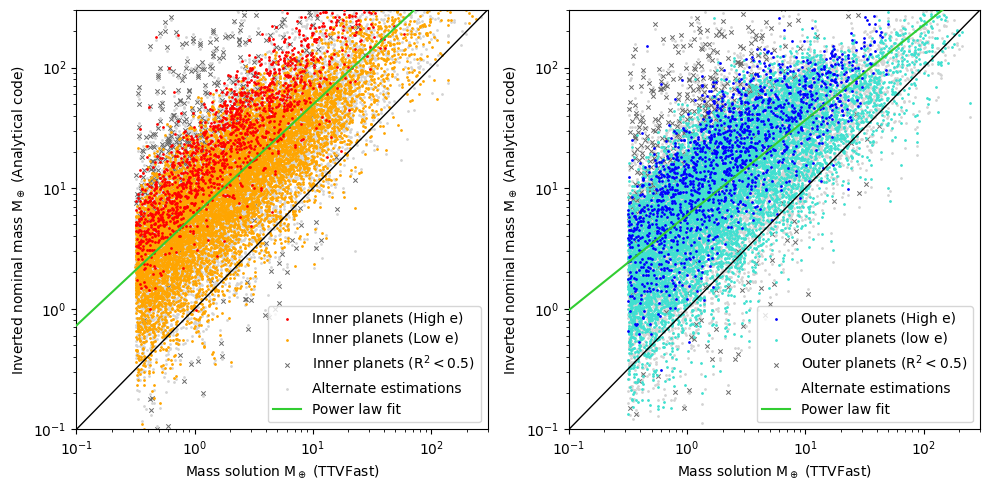

In [15]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 3e+2
linelim = np.array([minval, maxval])
scatterCount = len(compare_n['m1'])

ethres = 0.1
lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
Rthres = 0.5
lowR = (compare.R2_1 < Rthres) | (compare.R2_2 < Rthres); highR = ~lowR

# Inner planets
m1 = compare_n['m1']
m1_good = compare_n['m_calc_in']
m1_bad = compare_n['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1[highe &highR], m1_good[highe &highR], s=s, color='red', label=f'Inner planets (High e)', zorder=3)
ax[0].scatter(m1[lowe &highR], m1_good[lowe &highR], s=s, color='orange', label=f'Inner planets (Low e)', zorder=1)
ax[0].scatter(m1[lowR], m1_good[lowR], s=10*s, color='dimgrey', marker='x', lw=0.7, label=f'Inner planets (R$^2 < 0.5$)', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1)

ax[0].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', zorder=5, label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planet
m2 = compare_n['m2']
m2_good = compare_n['m_calc_out']
m2_bad = compare_n['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2[highe &highR], m2_good[highe &highR], s=s, color='blue', label=f'Outer planets (High e)', zorder=3)
ax[1].scatter(m2[lowe &highR], m2_good[lowe &highR], s=s, color='turquoise', label=f'Outer planets (low e)', zorder=1)
ax[1].scatter(m2[lowR], m2_good[lowR], s=10*s, color='dimgrey', marker='x', lw=0.7, label=f'Outer planets (R$^2 < 0.5$)', zorder=0)
ax[1].scatter(m2, m2_bad, s=s, color='lightgrey', label='Alternate estimations', zorder=-1)

ax[1].plot(linelim, linelim, color='black', lw=1, zorder=5)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', zorder=5, label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

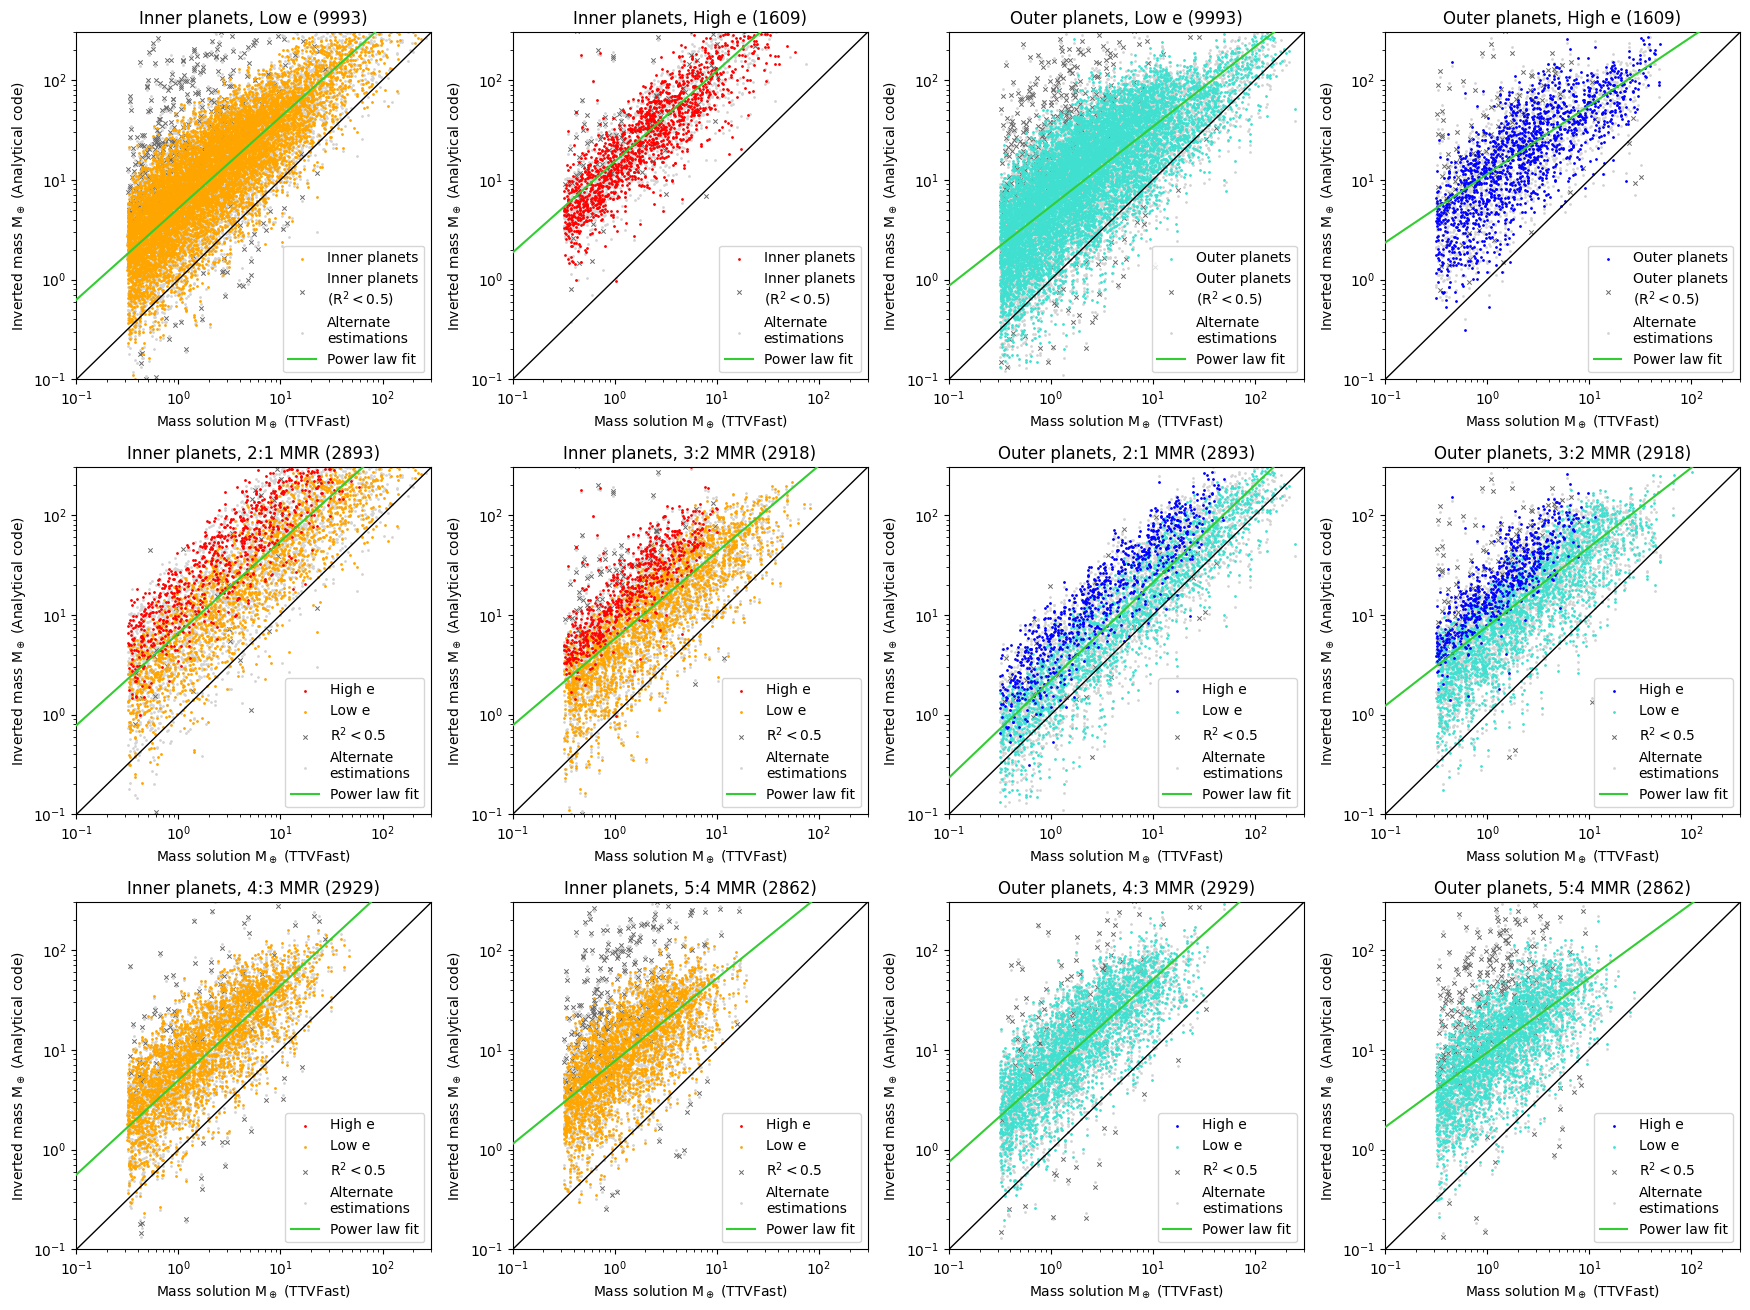

In [16]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(16*1.1, 12*1.1))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [17]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.779 dex, 0.784 dex, 0.396 dex
Geometric mean error, median error, and geometric STD (Outer): 0.722 dex, 0.742 dex, 0.440 dex


# Metric compilation

In [18]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (Overall, low e)', 'Inner (Overall, high e)',
                  'Inner (2:1 MMR, low e)', 'Inner (3:2 MMR, low e)', 'Inner (4:3 MMR, low e)', 'Inner (5:4 MMR, low e)',
                  'Inner (2:1 MMR, high e)', 'Inner (3:2 MMR, high e)', 'Inner (4:3 MMR, high e)', 'Inner (5:4 MMR, high e)',
                  'Outer (Overall)', 'Outer (Overall, low e)', 'Outer (Overall, high e)',
                  'Outer (2:1 MMR, low e)', 'Outer (3:2 MMR, low e)', 'Outer (4:3 MMR, low e)', 'Outer (5:4 MMR, low e)',
                  'Outer (2:1 MMR, high e)', 'Outer (3:2 MMR, high e)', 'Outer (4:3 MMR, high e)', 'Outer (5:4 MMR, high e)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Inner (Overall, low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Inner (Overall, high e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Inner (2:1 MMR, low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Inner (3:2 MMR, low e)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Regime definitions
ethres = 0.1
lowe = (compare.e1 < ethres) & (compare.e2 < ethres); highe = ~lowe
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_n, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for ioStr in ['Inner', 'Outer']:
    for regime in ['all', lowe, highe,
                   *[jmask(n) & lowe for n in range(2,6)],
                   *[jmask(n) & highe for n in range(2,6)]]:
        regime_with_no_samples = ((regime == (jmask(4) & highe)).all() == True) or ((regime == (jmask(5) & highe)).all() == True)
        if regime_with_no_samples:
            rowi = [0] + [np.nan] * 8
        else:
            rowi = createListToInsert(ioStr, m=regime)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),11602,0.031899,0.779332,0.018851,0.784394,-0.035069,0.407058,0.081118,1.141893
1,"Inner (Overall, low e)",9993,0.028627,0.722068,0.017868,0.732903,-0.034029,0.368565,0.076332,1.063209
2,"Inner (Overall, high e)",1609,0.052221,1.135135,0.028334,1.120076,-0.039283,0.876142,0.113089,1.38429
3,"Inner (2:1 MMR, low e)",2027,0.009733,0.62753,0.010012,0.641327,-0.061121,0.306079,0.083342,0.96321
4,"Inner (3:2 MMR, low e)",2175,0.010311,0.587607,0.008636,0.625307,-0.025957,0.277023,0.043768,0.895005
5,"Inner (4:3 MMR, low e)",2929,0.02564,0.729,0.017725,0.748208,-0.023727,0.40129,0.067117,1.059773
6,"Inner (5:4 MMR, low e)",2862,0.058984,0.884227,0.027617,0.882518,-0.020688,0.509934,0.114141,1.236273
7,"Inner (2:1 MMR, high e)",866,0.022128,1.109599,0.005949,1.13456,-0.054216,0.823435,0.106573,1.389987
8,"Inner (3:2 MMR, high e)",743,0.087296,1.164938,0.036496,1.108025,-0.013648,0.923749,0.125254,1.377815
9,"Inner (4:3 MMR, high e)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

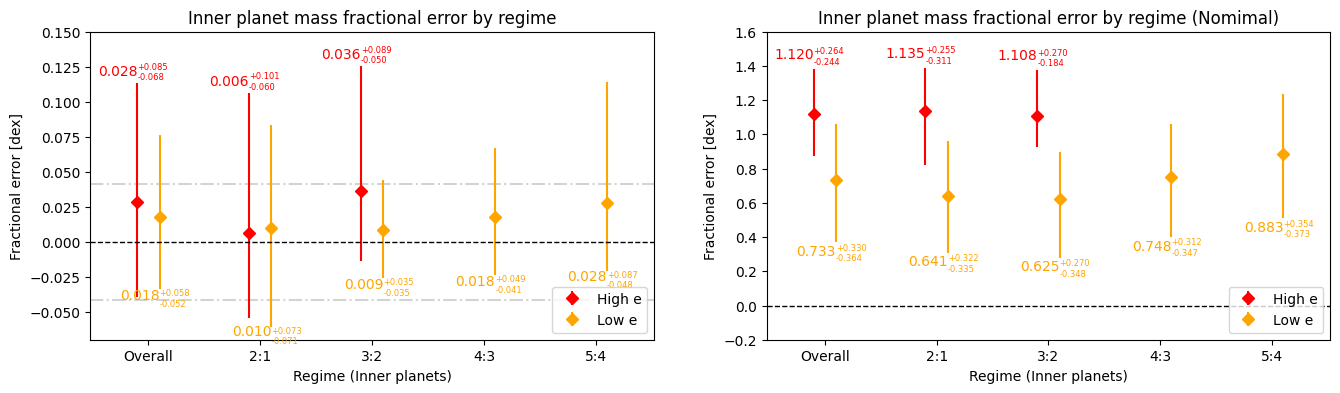

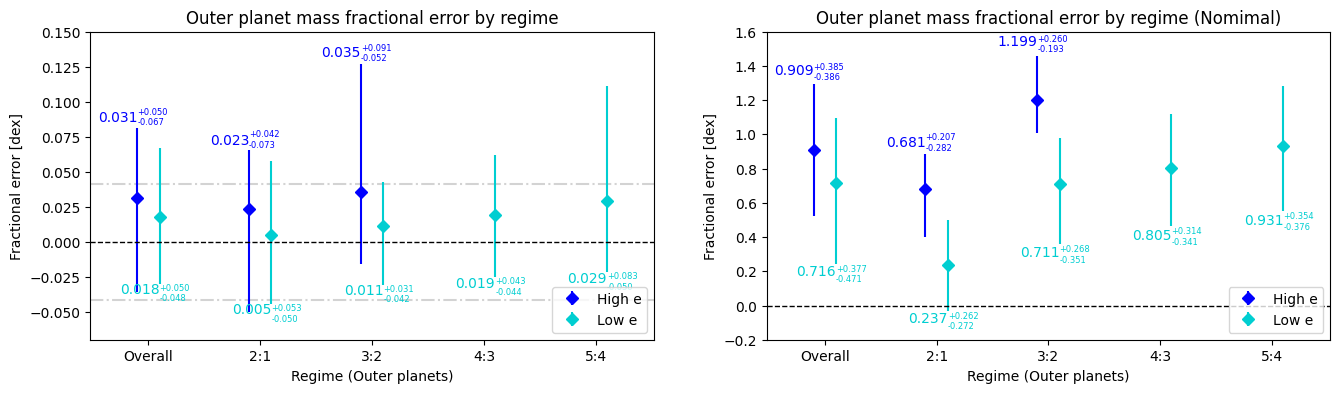

In [21]:
# Plot visualization
inner = metrics.iloc[0:11]; outer = metrics.iloc[11:22]
mmr_list = ['2:1', '3:2', '4:3', '5:4']

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', *mmr_list]
    ethres = 0.01
    highe = (compare.e1 > ethres) & (compare.e2 > ethres); lowe = ~highe
    
    colnames = ['Regime', 'Count', 'Geometric Mean Error [dex]', 'Geometric Mean Error (Nominal) [dex]',
                'Median Error [dex]', 'Median Error (Nominal) [dex]',
                'Error at 16th Percentile [dex]', 'Error at 16th Percentile (Nominal) [dex]',
                'Error at 84th Percentile [dex]', 'Error at 84th Percentile (Nominal) [dex]']

    # Define dfs of lowe and highe
    df_lowe = df.iloc[[1,3,4,5,6]]
    df_highe = df.iloc[[2,7,8,9,10]]

    # Extract errorbars
    def get_yerr(df_):
        yerr_lower = df_.MedErr - df_.p16Err
        yerr_upper = df_.p84Err - df_.MedErr
        yerr = [yerr_lower, yerr_upper]
        
        yerrn_lower = df_.MedErr_n - df_.p16Err_n
        yerrn_upper = df_.p84Err_n - df_.MedErr_n
        yerrn = [yerrn_lower, yerrn_upper]

        return yerr, yerrn
    
    yerr_lowe, yerrn_lowe = get_yerr(df_lowe)
    yerr_highe, yerrn_highe = get_yerr(df_highe)

    # Text color customization
    if innerOuterStr == "Inner":
        color_highe = 'red'; color_lowe = 'orange'
    elif innerOuterStr == "Outer":
        color_highe = 'blue'; color_lowe = 'darkturquoise'

    # Shift scatterplot to the left and right
    shift = 0.1
    x = np.arange(len(regimenames))
    xpos_highe = x - shift
    xpos_lowe = x + shift

    # Plot the graph
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].errorbar(x=xpos_highe, y=df_highe.MedErr, yerr=yerr_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[0].errorbar(x=xpos_lowe, y=df_lowe.MedErr, yerr=yerr_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[0].set_title(f'{innerOuterStr} planet mass fractional error by regime')
    ax[0].set_ylim(-0.07, 0.15)
    ax[0].legend(loc='lower right')
    
    ax[1].errorbar(x=xpos_highe, y=df_highe.MedErr_n, yerr=yerrn_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[1].errorbar(x=xpos_lowe, y=df_lowe.MedErr_n, yerr=yerrn_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[1].set_title(f'{innerOuterStr} planet mass fractional error by regime (Nomimal)')
    ax[1].set_ylim(-0.2, 1.6)
    ax[1].legend(loc='lower right')

    for i in range(5): # Text
        text_x_high, text_x_low = xpos_highe[i], xpos_lowe[i]
        s1 = 10
        s2 = 6

        def showText(df_, color, xpos):      
            upper = df_['p84Err'].iloc[i] - df_['MedErr'].iloc[i]
            lower = df_['MedErr'].iloc[i] - df_['p16Err'].iloc[i]
            # Limit text
            if color == color_highe:
                ypos = np.nan_to_num(np.clip(df_['p84Err'].iloc[i], 0.02, 0.2), nan=np.nan)
                scale1, scale2 = 1.03, 1.01
                va = 'bottom'
            elif color == color_lowe:
                ypos = min(df_['p16Err'].iloc[i], -0.02)
                scale1, scale2 = 0.97, 0.99
                va = 'top'

            if not np.isnan(ypos):
                ax[0].text(  # Median report
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[0].text(  # Errorbar report
                    xpos,
                    ypos * scale2,
                    f'+{upper:.3f}\n-{lower:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )
        
                upper_n = df_['p84Err_n'].iloc[i] - df_['MedErr_n'].iloc[i]
                lower_n = df_['MedErr_n'].iloc[i] - df_['p16Err_n'].iloc[i]
                # Again for nominal part of plot
                if color == color_highe:
                    ypos = df_['p84Err_n'].iloc[i]
                elif color == color_lowe:
                    ypos = df_['p16Err_n'].iloc[i]
                
                ax[1].text( # Right plot median + errorbar
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr_n.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[1].text(
                    xpos,
                    ypos * scale2,
                    f'+{upper_n:.3f}\n-{lower_n:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )

        showText(df_highe, color_highe, text_x_high)
        showText(df_lowe, color_lowe, text_x_low)

    # Rest of the common plot elements
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')
        a.set_xticks(x)
        a.set_xticklabels(regimenames)
        a.margins(x=0.1)
        
    ax[0].axhline(y=np.log10(1.1), color='lightgrey', zorder=-5, linestyle='-.')
    ax[0].axhline(y=-np.log10(1.1), color='lightgrey', zorder=-5, linestyle='-.')
    plt.show()

metricPlots(inner, 'Inner')
metricPlots(outer, 'Outer')

# Metric compilation (R^2 > 0.5)

In [22]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (Overall, low e)', 'Inner (Overall, high e)',
                  'Inner (2:1 MMR, low e)', 'Inner (3:2 MMR, low e)', 'Inner (4:3 MMR, low e)', 'Inner (5:4 MMR, low e)',
                  'Inner (2:1 MMR, high e)', 'Inner (3:2 MMR, high e)', 'Inner (4:3 MMR, high e)', 'Inner (5:4 MMR, high e)',
                  'Outer (Overall)', 'Outer (Overall, low e)', 'Outer (Overall, high e)',
                  'Outer (2:1 MMR, low e)', 'Outer (3:2 MMR, low e)', 'Outer (4:3 MMR, low e)', 'Outer (5:4 MMR, low e)',
                  'Outer (2:1 MMR, high e)', 'Outer (3:2 MMR, high e)', 'Outer (4:3 MMR, high e)', 'Outer (5:4 MMR, high e)']
metrics.head()

# New good R2 compare dataframe
Rthres = 0.5; 
highR = (compare.R2_1 > Rthres) & (compare.R2_2 > Rthres)
compare_good = compare[highR]; compare_ngood = compare_n[highR]

In [23]:
# Regime definitions
ethres = 0.1;
lowe = (compare_good.e1 < ethres) & (compare_good.e2 < ethres); highe = ~lowe
def jmask(n): 
    return (compare_good.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare_good, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_ngood, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare_good.m1) if (isinstance(m, str) == True) else len(compare_good.m1[m])
    return [count, *metrics]

rows = []
for ioStr in ['Inner', 'Outer']:
    for regime in ['all', lowe, highe,
                   *[jmask(n) & lowe for n in range(2,6)],
                   *[jmask(n) & highe for n in range(2,6)]]:
        regime_with_no_samples = ((regime == (jmask(4) & highe)).all() == True) or ((regime == (jmask(5) & highe)).all() == True)
        if regime_with_no_samples:
            rowi = [0] + [np.nan] * 8
        else:
            rowi = createListToInsert(ioStr, m=regime)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,p16Err,p16Err_n,p84Err,p84Err_n
0,Inner (Overall),11150,0.020852,0.757037,0.017424,0.770938,-0.035139,0.402175,0.071843,1.110369
1,"Inner (Overall, low e)",9660,0.019357,0.702839,0.016814,0.723309,-0.034032,0.36724,0.069636,1.034998
2,"Inner (Overall, high e)",1490,0.030543,1.108416,0.024687,1.108025,-0.039356,0.873581,0.090845,1.363018
3,"Inner (2:1 MMR, low e)",2021,0.010499,0.630102,0.010705,0.642685,-0.060398,0.310235,0.083584,0.963459
4,"Inner (3:2 MMR, low e)",2171,0.010226,0.589032,0.008688,0.625322,-0.025719,0.277914,0.043733,0.894575
5,"Inner (4:3 MMR, low e)",2838,0.020039,0.72055,0.016898,0.740781,-0.023475,0.40346,0.062343,1.037398
6,"Inner (5:4 MMR, low e)",2630,0.032967,0.833565,0.024206,0.860216,-0.020935,0.493111,0.090915,1.162306
7,"Inner (2:1 MMR, high e)",838,0.021952,1.114566,0.006332,1.140308,-0.05295,0.830453,0.10132,1.387974
8,"Inner (3:2 MMR, high e)",652,0.041584,1.100513,0.031722,1.073881,-0.015776,0.907702,0.083804,1.309238
9,"Inner (4:3 MMR, high e)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Export metrics
metrics.to_csv('lithwick_code_metrics_goodR2.csv', index=False)

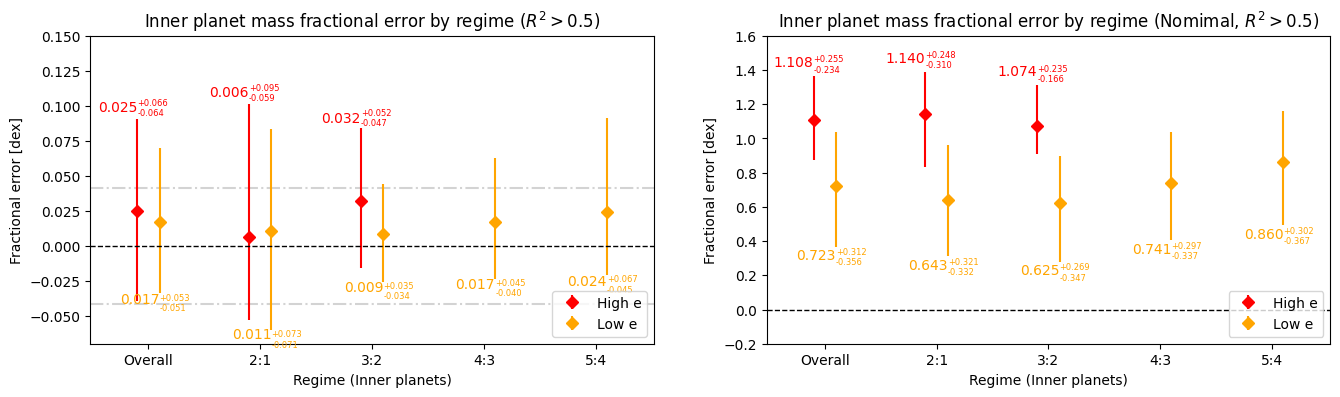

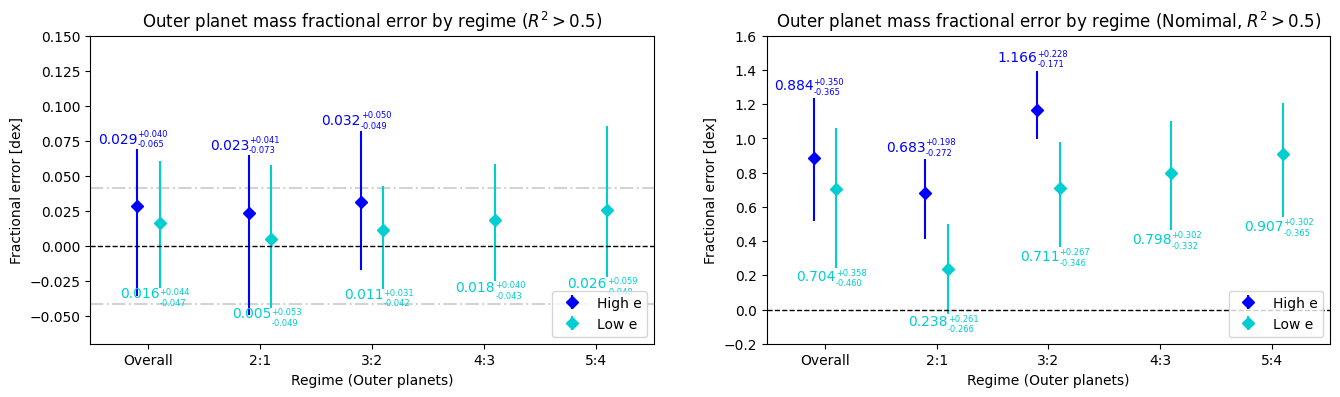

In [25]:
# Plot visualization
inner = metrics.iloc[0:11]; outer = metrics.iloc[11:22]
mmr_list = ['2:1', '3:2', '4:3', '5:4']

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', *mmr_list]
    ethres = 0.01
    highe = (compare_good.e1 > ethres) & (compare_good.e2 > ethres); lowe = ~highe
    
    colnames = ['Regime', 'Count', 'Geometric Mean Error [dex]', 'Geometric Mean Error (Nominal) [dex]',
                'Median Error [dex]', 'Median Error (Nominal) [dex]',
                'Error at 16th Percentile [dex]', 'Error at 16th Percentile (Nominal) [dex]',
                'Error at 84th Percentile [dex]', 'Error at 84th Percentile (Nominal) [dex]']

    # Define dfs of lowe and highe
    df_lowe = df.iloc[[1,3,4,5,6]]
    df_highe = df.iloc[[2,7,8,9,10]]

    # Extract errorbars
    def get_yerr(df_):
        yerr_lower = df_.MedErr - df_.p16Err
        yerr_upper = df_.p84Err - df_.MedErr
        yerr = [yerr_lower, yerr_upper]
        
        yerrn_lower = df_.MedErr_n - df_.p16Err_n
        yerrn_upper = df_.p84Err_n - df_.MedErr_n
        yerrn = [yerrn_lower, yerrn_upper]

        return yerr, yerrn
    
    yerr_lowe, yerrn_lowe = get_yerr(df_lowe)
    yerr_highe, yerrn_highe = get_yerr(df_highe)

    # Text color customization
    if innerOuterStr == "Inner":
        color_highe = 'red'; color_lowe = 'orange'
    elif innerOuterStr == "Outer":
        color_highe = 'blue'; color_lowe = 'darkturquoise'

    # Shift scatterplot to the left and right
    shift = 0.1
    x = np.arange(len(regimenames))
    xpos_highe = x - shift
    xpos_lowe = x + shift

    # Plot the graph
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].errorbar(x=xpos_highe, y=df_highe.MedErr, yerr=yerr_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[0].errorbar(x=xpos_lowe, y=df_lowe.MedErr, yerr=yerr_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[0].set_title(f'{innerOuterStr} planet mass fractional error by regime ($R^2 > 0.5$)')
    ax[0].set_ylim(-0.07, 0.15)
    ax[0].legend(loc='lower right')
    
    ax[1].errorbar(x=xpos_highe, y=df_highe.MedErr_n, yerr=yerrn_highe,
                   fmt='D', linestyle='none', color=color_highe, zorder=1, label='High e')
    ax[1].errorbar(x=xpos_lowe, y=df_lowe.MedErr_n, yerr=yerrn_lowe,
                   fmt='D', linestyle='none', color=color_lowe, zorder=0, label='Low e')
    ax[1].set_title(f'{innerOuterStr} planet mass fractional error by regime (Nomimal, $R^2 > 0.5$)')
    ax[1].set_ylim(-0.2, 1.6)
    ax[1].legend(loc='lower right')

    for i in range(5): # Text
        text_x_high, text_x_low = xpos_highe[i], xpos_lowe[i]
        s1 = 10
        s2 = 6

        def showText(df_, color, xpos):      
            upper = df_['p84Err'].iloc[i] - df_['MedErr'].iloc[i]
            lower = df_['MedErr'].iloc[i] - df_['p16Err'].iloc[i]
            # Limit text
            if color == color_highe:
                ypos = np.nan_to_num(np.clip(df_['p84Err'].iloc[i], 0.02, 0.2), nan=np.nan)
                scale1, scale2 = 1.03, 1.01
                va = 'bottom'
            elif color == color_lowe:
                ypos = min(df_['p16Err'].iloc[i], -0.02)
                scale1, scale2 = 0.97, 0.99
                va = 'top'

            if not np.isnan(ypos):
                ax[0].text(  # Median report
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[0].text(  # Errorbar report
                    xpos,
                    ypos * scale2,
                    f'+{upper:.3f}\n-{lower:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )
        
                upper_n = df_['p84Err_n'].iloc[i] - df_['MedErr_n'].iloc[i]
                lower_n = df_['MedErr_n'].iloc[i] - df_['p16Err_n'].iloc[i]
                # Again for nominal part of plot
                if color == color_highe:
                    ypos = df_['p84Err_n'].iloc[i]
                elif color == color_lowe:
                    ypos = df_['p16Err_n'].iloc[i]
                
                ax[1].text( # Right plot median + errorbar
                    xpos,
                    ypos * scale1,
                    f'{df_.MedErr_n.iloc[i]:.3f}',
                    fontsize=s1, color=color,
                    ha='right', va=va
                )
                ax[1].text(
                    xpos,
                    ypos * scale2,
                    f'+{upper_n:.3f}\n-{lower_n:.3f}',
                    fontsize=s2, color=color,
                    ha='left', va=va
                )

        showText(df_highe, color_highe, text_x_high)
        showText(df_lowe, color_lowe, text_x_low)

    # Rest of the common plot elements
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')
        a.set_xticks(x)
        a.set_xticklabels(regimenames)
        a.margins(x=0.1)
    ax[0].axhline(y=np.log10(1.1), color='lightgrey', zorder=-5, linestyle='-.')
    ax[0].axhline(y=-np.log10(1.1), color='lightgrey', zorder=-5, linestyle='-.')
    
    plt.show()

metricPlots(inner, 'Inner')
metricPlots(outer, 'Outer')